# An Optical Cavity

In this section, we will cover the simple case of modelling resonances in a Fabry-Perot cavity as a starting point.

## The Optical Configuration

In the figure below we show the layout that we want to model. This consists of an input laser incident upon a two-mirror optical cavity. Measuring the reflected, transmitted and circulating power requires the use of three photodiodes - PD$_{\text{refl}}$, PD$_{\text{trans}}$ and PD$_{\text{circ}}$, respectively. 

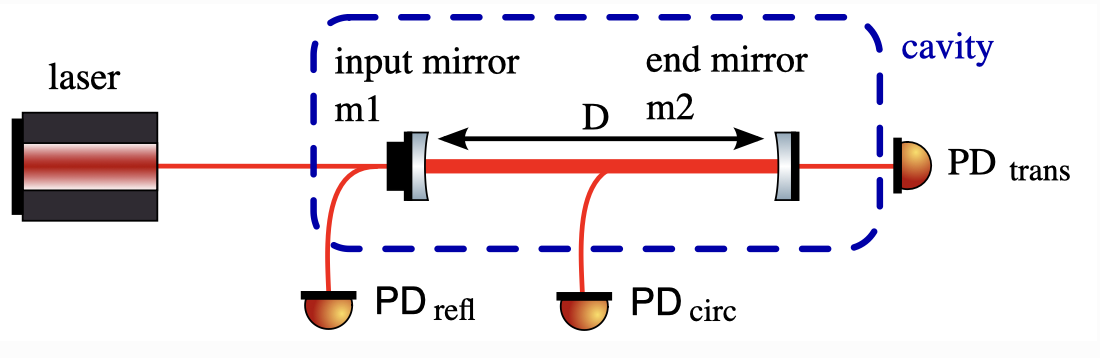

To find the resonances of this cavity we can either change the tuning(s) of the mirrors or scan over the frequency of the input laser. In this case, we will alter the tuning of the input mirror, **m1**, in the range $\varphi_{\text{m1}} \in [-180\degree , 180\degree ]$ to show multiple (repeated) resonances.

## The Finesse model

To represent the above layout with a FINESSE model we can write the following Python code:

In [8]:
import finesse
finesse.configure(plotting=True)

kat = finesse.Model()
kat.parse(
    """
    # Add a Laser named L0 with a power of 1 W.
    l L0 P=1

    # Space attaching L0 <-> m1 with length of 0 m (default).
    s s0 L0.p1 m1.p1

    # Input mirror of cavity.
    m m1 R=0.99 T=0.01

    # Intra-cavity space with length of 1 m.
    s CAV m1.p2 m2.p1 L=1

    # End mirror of cavity.
    m m2 R=0.991 T=0.009

    # Power detectors on reflection, circulation and transmission.
    pd refl m1.p1.o
    pd circ m2.p1.i
    pd trns m2.p2.o

    # Scan over the detuning DOF of m1 from -180 deg to +180 deg with 400 points.
    xaxis(m1.phi, lin, -180, 180, 400)
    """
)

Firstly, we call **configure()** with **plotting=True**. This sets up some defaults for plotting styles, such as line colours and font size. Next, we create a new **Model**, and then parse our KatScript (see *KatScript* for more details on the syntax used). This creates a model of a Fabry-Perot cavity with a length of 1 metre and nerly equal reflectivities on both the input mirror and end mirror. The input laser power is set to 1 W.

The last line isn’t part of the model, but defines an **Action** that will operate on the model. In this case it is an **Xaxis**, which sweeps some parameter of the model between two limits.

## Plotting the Outputs

To run this model and plot the outputs from the power-detectors, we can simply write:

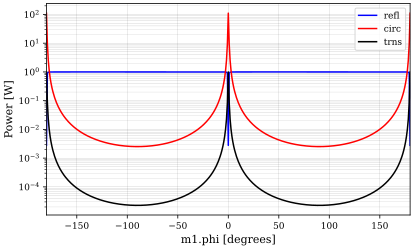

In [2]:
out = kat.run()
out.plot(logy=True);

The call to **run()** causes the **Xaxis** we defined before to run on the model. This returns an **ArraySolution**, containing the output of each detector at each point on the axis. We then plot the detector outputs, via **plot()**. The **logy** flag tells the plotting routines to use a log-scale on the y-axis of any produced figures.

## Plotting the Beam Profile

To plot the beam profile, we need to add some curvatures to our mirrors and define the cavity. This will implicitly switch the simulation performed by FINESSE from plane wave to Hermite-Gaussian.

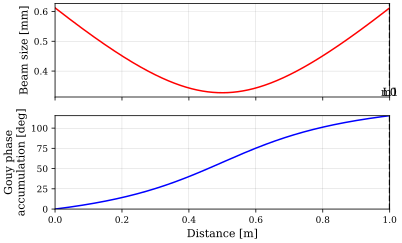

In [3]:
# Add some curvatures to our mirrors.
kat.m1.Rc = -0.7
kat.m2.Rc = 0.7

# Define the cavity.
kat.parse("cavity cavity1 source=m1.p2.o via=m2.p1.i priority=1")

# Plot the beam trace, starting from cavity the eigenmode.
tsy = finesse.tracing.tools.propagate_beam(
    to_node=kat.L0.p1.i, from_node=kat.m2.p1.o, direction="y"
)
tsy.plot();

The resulting plot shows the cavity eigenmode. To make the plot more interesting, we could add a lens to the input coupler. To do this, we build a compound mirror:

Intent-preserving regeneration of KatScript for operations has not been implemented yet. These have instead been generated using default formatting (this does not affect the validity of the generated KatScript).


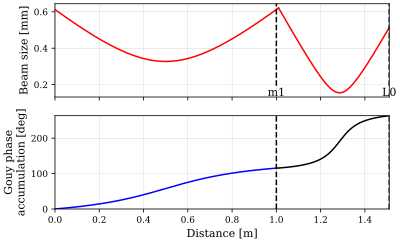

In [4]:
# Remove s0 so we can add in a lens.
# FIXME kat.remove is not yet working, so we use a list
# comprehension to remove s0 from the model and
# reparse it into a new model. (See unparse below)
kat2 = finesse.Model()
kat2.parse(
    "\n".join(
        [l for l in kat.unparse().splitlines() if "s0" not in l]
    )
)

# Add a silicon lens with an AR surface to the input coupler.
kat2.parse(
    """
    space s0 L0.p1 m1_AR.p1 L=0.5
    mirror m1_AR R=100e-6 L=10e-6 Rc=-0.3
    space s_M1_sub portA=m1_AR.p2 portB=m1.p1 L=10e-3 nr=3.5
    """
)

# Plot beam trace, starting from the cavity eigenmode.
tsy = finesse.tracing.tools.propagate_beam(
    to_node=kat2.L0.p1.i, from_node=kat2.m2.p1.o, direction="y"
)
tsy.plot();

## Printing Model Information

There are three options for outputting a textual summary of the model. Firstly, printing the model directly gives the usual Python object information:

In [5]:
print(kat)

Secondly, you can output a tree view of the nodal network with components as nodes and connected components as branches. Such a tree can be printed in the following way:

In [6]:
print(kat.component_tree(kat.L0))

○ L0
╰──○ m1
   ╰──○ m2


The argument to **component_tree()** is the component to start from (the tree’s root). Any component in the model can be the tree root.

> Note: Models that contain cyclic connections (such as Sagnax interferometers) will not show one of the connections that would create the cycle, to prevent infinite recursion.

Lastly, the most verbose option is to **unparse()** the model. This returns KatScript which can be reused to create the model.

In [9]:
print(kat.unparse())

Intent-preserving regeneration of KatScript for operations has not been implemented yet. These have instead been generated using default formatting (this does not affect the validity of the generated KatScript).



    # Add a Laser named L0 with a power of 1 W.
    l L0 P=1

    # Space attaching L0 <-> m1 with length of 0 m (default).
    s s0 L0.p1 m1.p1

    # Input mirror of cavity.
    m m1 R=0.99 T=0.01 L=0.0

    # Intra-cavity space with length of 1 m.
    s CAV m1.p2 m2.p1 L=1

    # End mirror of cavity.
    m m2 R=0.991 T=0.009 L=0.0

    # Power detectors on reflection, circulation and transmission.
    pd refl m1.p1.o
    pd circ m2.p1.i
    pd trns m2.p2.o

    # Scan over the detuning DOF of m1 from -180 deg to +180 deg with 400 points.
    xaxis(m1.phi, lin, -180, 180, 400)
    
# Items below could not be matched to original script, or were not present when the model was originally parsed.





